In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
from tensorflow.keras.layers import Dense, Input, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0*2-1, x_test/255.0*2-1
print(x_train.shape)

(60000, 28, 28)


In [0]:
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [0]:
latent_dim = 100

In [0]:
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(1028, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.8)(x)
  x = Dense(D, activation='tanh')(x)
  
  model = Model(i, x)
  return model

In [0]:
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [0]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    metrics=['accuracy'],
    optimizer=Adam(0.0002, 0.5)
)
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model = Model(z, fake_pred)
combined_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5)
)


In [0]:
batch_size = 32
epochs = 30000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
d_losses = []
g_losses = []
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [0]:
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [24]:
for epoch in range(epochs):
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss= 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch:{epoch+1}/{epochs}, d_loss: {d_loss:.2f},d_acc:{d_acc:.2f}, g_loss:{g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)
  

epoch:1/30000, d_loss: 0.79,d_acc:0.36, g_loss:0.60
epoch:101/30000, d_loss: 0.01,d_acc:1.00, g_loss:4.48
epoch:201/30000, d_loss: 0.10,d_acc:0.97, g_loss:4.44
epoch:301/30000, d_loss: 0.65,d_acc:0.69, g_loss:1.87
epoch:401/30000, d_loss: 0.42,d_acc:0.80, g_loss:2.33
epoch:501/30000, d_loss: 0.72,d_acc:0.38, g_loss:0.69
epoch:601/30000, d_loss: 0.68,d_acc:0.45, g_loss:0.67
epoch:701/30000, d_loss: 0.64,d_acc:0.64, g_loss:0.74
epoch:801/30000, d_loss: 0.67,d_acc:0.56, g_loss:0.72
epoch:901/30000, d_loss: 0.65,d_acc:0.58, g_loss:0.78
epoch:1001/30000, d_loss: 0.61,d_acc:0.67, g_loss:0.80
epoch:1101/30000, d_loss: 0.64,d_acc:0.64, g_loss:0.84
epoch:1201/30000, d_loss: 0.54,d_acc:0.84, g_loss:0.88
epoch:1301/30000, d_loss: 0.59,d_acc:0.73, g_loss:0.85
epoch:1401/30000, d_loss: 0.61,d_acc:0.66, g_loss:0.90
epoch:1501/30000, d_loss: 0.54,d_acc:0.81, g_loss:1.01
epoch:1601/30000, d_loss: 0.59,d_acc:0.72, g_loss:1.00
epoch:1701/30000, d_loss: 0.52,d_acc:0.78, g_loss:1.02
epoch:1801/30000, d_lo

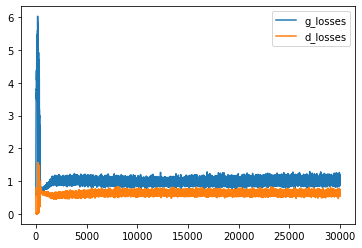

In [25]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [0]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

In [28]:
a = imread('gan_images/1000.png')
plt.imshow(a)

NameError: ignored

In [0]:
a = imread('gan_images/5000.png')
plt.imshow(a)

In [0]:
a = imread('gan_images/10000.png')
plt.imshow(a)

In [0]:
a = imread('gan_images/20000.png')
plt.imshow(a)

In [27]:
a = imread('gan_images/29800.png')
plt.imshow(a)

NameError: ignored